In [ ]:
# pip install gensim==4.0.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as api
from nltk.tokenize import wordpunct_tokenize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from utils import train_model, plot_train_process
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [4]:
import seaborn as sns

In [7]:
%load_ext autoreload
%autoreload 2
%aimport utils

In [8]:
RS = 42  # random seed

np.random.seed(RS)
torch.manual_seed(RS)

# Загрузка и предобработка данных.

In [9]:
train_df = pd.read_parquet('/content/drive/MyDrive/TZ/KazExp/train.parquet')

In [10]:
test_df = pd.read_parquet('/content/drive/MyDrive/TZ/KazExp/test.parquet')

In [11]:
cat_tree = pd.read_csv('/content/drive/MyDrive/TZ/KazExp/categories_tree.csv')

In [12]:
train_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


In [13]:
test_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0


In [14]:
cat_tree.head()

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [15]:
print(train_df.shape)
print(test_df.shape)

(283452, 7)
(70864, 6)


In [ ]:
# Токенизируем слова в стоблцах title, short_description, name_value_characteristics

In [16]:
train_df['title_tokenized'] = train_df['title'].apply(lambda x: wordpunct_tokenize(x.lower()))
test_df['title_tokenized'] = test_df['title'].apply(lambda x: wordpunct_tokenize(x.lower()))

In [17]:
train_df['descr_tokenized'] = train_df['short_description'].apply(lambda x: wordpunct_tokenize(x.lower()) if x else [])
test_df['descr_tokenized'] = test_df['short_description'].apply(lambda x: wordpunct_tokenize(x.lower()) if x else [])

In [18]:
train_df['char_tokenized'] = train_df['name_value_characteristics'].apply(lambda x: wordpunct_tokenize(x.lower()) if x else [])
test_df['char_tokenized'] = test_df['name_value_characteristics'].apply(lambda x: wordpunct_tokenize(x.lower()) if x else [])

# Обучение эмбеддингов.

In [19]:
text_features = ['title_tokenized', 'descr_tokenized', 'char_tokenized']

all_txt_data = pd.concat([train_df[text_features], test_df[text_features]], axis=0) 

In [20]:
all_txt_data.shape

(354316, 3)

In [21]:
all_txt_data.head(2)

,title_tokenized,descr_tokenized,char_tokenized
0,"[muhle, manikure, песочные, колпачки, для, пед...","[muhle, manikure, колпачок, песочный, шлифовал...",[]
1,"[sony, xperia, l1, защитное, стекло, 2, ,, 5d]",[],[]


In [22]:
# Объединим весь имеющийся текст в один список для обучения эмбеддингов

titles = all_txt_data.title_tokenized.tolist()
descriptions = all_txt_data.descr_tokenized.tolist()
characteristics = all_txt_data.char_tokenized.tolist()

train_data = titles + descriptions + characteristics

In [23]:
print('Обучение эмбеддингов на {} примерах'.format(len(train_data)))

Обучение эмбеддингов на 1062948 примерах


In [ ]:
# Обучим Word2Vec модель

model_wv = Word2Vec(
    train_data,
    vector_size=32,  
    min_count=2,  
    window=3,
    hs=1,
    sg=1,
    epochs=30  
).wv

In [5]:
model_wv = KeyedVectors.load("word2vec.wordvectors_e30_vs32")

In [6]:
model_wv.most_similar('шампунь')

[('кондиционер', 0.9597086906433105),
 ('бессульфатный', 0.9305416941642761),
 ('укрепляющий', 0.9257720112800598),
 ('восстанавливающий', 0.9174386858940125),
 ('разглаживающий', 0.9076172709465027),
 ('insight', 0.9048283696174622),
 ('nexprof', 0.9024097323417664),
 ('безсульфатный', 0.9014188647270203),
 ('истощенных', 0.8977724313735962),
 ('несмываемый', 0.8974649906158447)]

In [ ]:
# Сохраним модель

word_vectors = model_wv

word_vectors.save("word2vec.wordvectors_e30_vs32")

# Предобработка фичей и таргета для обучения NN.

In [24]:
def get_phrase_embedding(phrase, model=model_wv):
    """Return phrase embedding

    input: 
    phrase - list of tokens
    model - trained word2vec model

    returns: numpy array of embeddings averaged over all tokens in phrase 
    """
    word_vectors = np.array([model.get_vector(word) for word in phrase if word in model])
    if word_vectors.size == 0:
        return np.zeros(model.vector_size)

    return np.array(word_vectors).mean(axis=0)

In [ ]:
# Векторизуем текстовые фичи в тренировочной и тестовой выборках

In [25]:
title_emb_train = np.vstack([get_phrase_embedding(title) for title in train_df['title_tokenized']])
title_emb_test = np.vstack([get_phrase_embedding(title) for title in test_df['title_tokenized']])

In [26]:
descr_emb_train = np.vstack([get_phrase_embedding(descr) for descr in train_df['descr_tokenized']])
descr_emb_test = np.vstack([get_phrase_embedding(descr) for descr in test_df['descr_tokenized']])

In [27]:
char_emb_train = np.vstack([get_phrase_embedding(char) for char in train_df['char_tokenized']])
char_emb_test = np.vstack([get_phrase_embedding(char) for char in test_df['char_tokenized']])

In [ ]:
# Нормализуем числовые фичи в тренировочной и тестовой выборках

In [28]:
train_rating_mean = train_df['rating'].mean()
train_rating_std = train_df['rating'].std() 

train_rating_scaled = ((train_df['rating'] - train_rating_mean) / train_rating_std).to_numpy()
test_rating_scaled = ((test_df['rating'] - train_rating_mean) / train_rating_std).to_numpy()

In [29]:
train_feedback_mean = train_df['feedback_quantity'].mean()
train_feedback_std = train_df['feedback_quantity'].std() 

train_feedback_scaled = ((train_df['feedback_quantity'] - train_feedback_mean) / train_feedback_std).to_numpy()
test_feedback_scaled = ((test_df['feedback_quantity'] - train_feedback_mean) / train_feedback_std).to_numpy()

In [ ]:
# Соберем полученные признаки для тренировочного и тестового наборов

In [30]:
X = np.hstack([title_emb_train, descr_emb_train, char_emb_train, train_rating_scaled.reshape(-1, 1), train_feedback_scaled.reshape(-1, 1)])

In [31]:
X_test = np.hstack([title_emb_test, descr_emb_test, char_emb_test, test_rating_scaled.reshape(-1, 1), test_feedback_scaled.reshape(-1, 1)])

In [32]:
print(X.shape)
print(X_test.shape)

(283452, 98)
(70864, 98)


In [ ]:
# Закодируем таргеты

In [33]:
le = preprocessing.LabelEncoder()

le.fit(train_df['category_id'])

LabelEncoder()

In [34]:
y = le.transform(train_df['category_id'])

In [35]:
assert train_df['category_id'].nunique() == pd.DataFrame(y).nunique()[0]

In [36]:
# Создадим выборку для валидации

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [37]:
print(X_train.shape)
print(X_val.shape)

(198416, 98)
(85036, 98)


In [38]:
print(y_train.shape)
print(y_val.shape)

(198416,)
(85036,)


In [ ]:
# Приведем данные в формат torch.Tensor

In [39]:
X_train_torch = torch.Tensor(X_train)
X_val_torch = torch.Tensor(X_val)
X_test_torch = torch.Tensor(X_test)

y_train_torch = torch.Tensor(y_train).long()
y_val_torch = torch.Tensor(y_val).long()

In [40]:
n_in = X_train.shape[1]  # размерность входа нейросети 
n_out = train_df['category_id'].nunique()  # размерность выхода нейросети

In [41]:
n_in, n_out

(98, 1231)

# Обучение полносвязной нейросетевой модели.

In [42]:
def count_parameters(model):
    """Returns number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
def lr(step):
    """Returns sheduler update rule at every iteration"""
    return 0.1 + 0.9 * (0.998) ** step

def make_lr_scheduler(optimizer):
    """Returns scheduler object"""
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

In [67]:
def init_weights(layer):
    """Function to initialize weights in Linear layers"""
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)

In [87]:
model = nn.Sequential(nn.Linear(n_in, 3 * n_in), 
                      nn.ReLU(),
                      nn.BatchNorm1d(3 * n_in),
                      nn.Linear(3 * n_in, n_out))

In [88]:
model.apply(init_weights)

Sequential(
  (0): Linear(in_features=98, out_features=294, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(294, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=294, out_features=1231, bias=True)
)

In [89]:
print('Количество обучаемых параметров в модели: {}'.format(count_parameters(model)))

Количество обучаемых параметров в модели: 392839


In [90]:
# В качестве функции потерь используем взвешенную кросс-энтропию
# Значение весов для каждого класса определим пропорционально частоте встречаемости в исходном корпусе

unique, counts = np.unique(y, return_counts=True)
class_weights = counts / counts.sum()
class_weights_torch = torch.Tensor(class_weights)

In [91]:
loss_function = nn.CrossEntropyLoss(weight=class_weights_torch)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = make_lr_scheduler(opt)

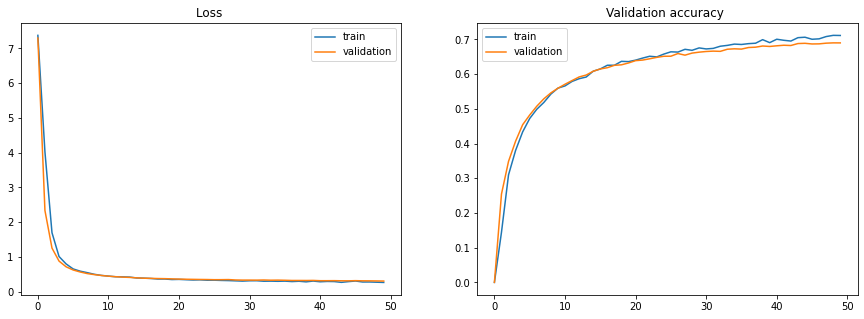

In [92]:
model_fcnn = train_model(model, opt, loss_function, lr_scheduler, X_train_torch, y_train_torch, X_val_torch, y_val_torch, n_iterations=5000, batch_size=256)

In [80]:
torch.save(model_fcnn.state_dict(), 'model_fcnn')  # сохраним модель

In [ ]:
# Сгенерируем предсказания

In [128]:
output = model_fcnn(X_test_torch)

In [129]:
pred_labels = torch.argmax(output, dim=1)

In [130]:
pred_labels = pred_labels.cpu().detach().numpy()

In [131]:
predictions = le.inverse_transform(pred_labels)

In [106]:
test_df['predicted_category_id'] = predictions

In [107]:
test_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,title_tokenized,descr_tokenized,char_tokenized,predicted_category_id
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0,"[браслет, из, натуральных, камней, lotus]",[],[],11574
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6,"[fusion, life, -, шампунь, для, сухих, и, окра...",[],[],11878
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24,"[микрофон, для, пк, jack, 3, ,, 5мм, всенаправ...","[универсальный, 3, ,, 5, мм, микрофон, запишет...",[],13299
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0,"[серьги, гвоздики, сердце]","[серьги, гвоздики, сердце]",[],13061
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0,"[чёрно, -, красная, стильная, брошь, "", тюльпа...","[стильная, и, яркая, брошь, ручной, работы, !,...",[],12813


In [143]:
# Проверим первые 5 предсказаний модели

cat_tree[cat_tree['id'].isin([11574, 11878, 13299, 13061, 12813])]

,id,title,parent_id
828,11574,Браслеты,10104
1097,11878,Шампуни,10705
1920,12813,Броши,10104
2141,13061,Серьги,10104
2352,13299,Микрофоны,10374


In [ ]:
# Сохраним результаты предсказаний

In [144]:
result = test_df[['id', 'predicted_category_id']]

In [145]:
result.head()

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813


In [149]:
result.to_parquet('result.parquet')